<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%204%20-%20Lesson%202%20-%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt \
    -O /tmp/irish-lyrics-eof.txt

--2020-09-16 13:53:37--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.20.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘/tmp/irish-lyrics-eof.txt’

/tmp/irish-lyrics-e 100%[===================>]  67.35K  --.-KB/s    in 0.001s  

2020-09-16 13:53:37 (94.1 MB/s) - ‘/tmp/irish-lyrics-eof.txt’ saved [68970/68970]



In [5]:
tokenizer = Tokenizer()

data = open('/tmp/irish-lyrics-eof.txt').read()

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)

#as word index start from 1, but we have padding values which is 0
# so total words including 0 is word.index+1
total_words = len(tokenizer.word_index) + 1

#print(tokenizer.word_index)
print(total_words)


2690


In [7]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [8]:
print(tokenizer.word_index['in'])
print(tokenizer.word_index['the'])
print(tokenizer.word_index['town'])
print(tokenizer.word_index['of'])
print(tokenizer.word_index['athy'])
print(tokenizer.word_index['one'])
print(tokenizer.word_index['jeremy'])
print(tokenizer.word_index['lanigan'])

8
1
71
6
713
39
1790
1791


In [9]:
print(xs[6])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]


In [10]:
print(ys[6])

[0. 0. 0. ... 0. 0. 0.]


In [11]:
print(xs[5])
print(ys[5])

[   0    0    0    0    0    0    0    0    0   51   12   96 1217   48
    2]
[0. 0. 0. ... 0. 0. 0.]


In [13]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(xs, ys, epochs=100, verbose=1)
#print model.summary()
print(model)


Epoch 1/100
377/377 [==============================] - 4s 10ms/step - loss: 6.6722 - accuracy: 0.0724
Epoch 2/100
377/377 [==============================] - 4s 10ms/step - loss: 5.8091 - accuracy: 0.1128
Epoch 3/100
377/377 [==============================] - 4s 10ms/step - loss: 4.9764 - accuracy: 0.1582
Epoch 4/100
377/377 [==============================] - 4s 10ms/step - loss: 4.1132 - accuracy: 0.2221
Epoch 5/100
377/377 [==============================] - 4s 10ms/step - loss: 3.2830 - accuracy: 0.3183
Epoch 6/100
377/377 [==============================] - 4s 10ms/step - loss: 2.5945 - accuracy: 0.4212
Epoch 7/100
377/377 [==============================] - 4s 10ms/step - loss: 2.1046 - accuracy: 0.5090
Epoch 8/100
377/377 [==============================] - 4s 10ms/step - loss: 1.8890 - accuracy: 0.5572
Epoch 9/100
377/377 [==============================] - 4s 10ms/step - loss: 1.6814 - accuracy: 0.6006
Epoch 10/100
377/377 [==============================] - 4s 10ms/step - loss: 1.366

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

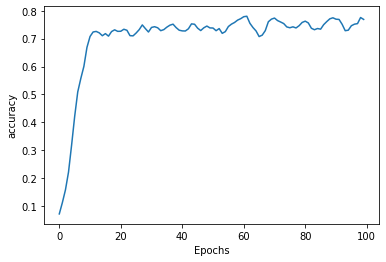

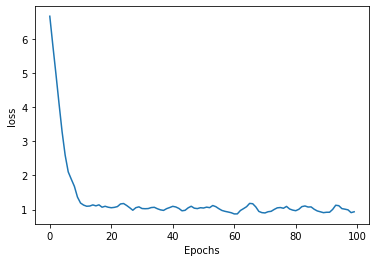

In [16]:
plot_graphs(history, 'accuracy')
plot_graphs(history,'loss')


In [56]:
seed_text = "long time"
next_words = 10
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

long time ago came we can sit and sport and play wid


Another Seed Text And Completion Method

In [29]:
def mergeInputAndPrediction(input,prediction):
  for i in range(len(input)):
    if input[i]!=0:
      break
  # do sliding
  j = i
  for j in range(len(input)):
    if j>0:
      input[j-1] = input[j]  
  input[j] = prediction

reversed_word_index = dict([(value,key) for (key,value) in tokenizer.word_index.items()])


In [57]:
seed_text = "long time"
next_words = 10
print(seed_text,end='')


sequence_seed = tokenizer.texts_to_sequences([seed_text])
pad_seed = pad_sequences(sequence_seed,maxlen=max_sequence_len-1,padding='pre')

for i in range(next_words):
  predicted_word = model.predict_classes(pad_seed)[0]
  print("",reversed_word_index[predicted_word],end='')
  mergeInputAndPrediction(pad_seed[0],predicted_word)






long time ago came we can sit and sport and play wid